# Automatic Differentiation for Matrices (Differentiable Programming)

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Prerequisites](#Prerequisites)
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)
* [Exercises](#Exercises)
  * [Derivative of the dot product](#Derivative-of-the-dot-product)
  * [Autodiff class Node](#Autodiff-class-%3Ccode%3ENode%3C%2Fcode%3E)
  * [2D Helper](#2D-Helper)
  * [Operators](#Operators)
  * [Operators - Multiply](#Operators---multiply)
  * [Broadcasting](#Broadcasting)
  * [Operators - Dot product](#Operators---Dot-product)
  * [Operators - Square](#Operators---Square)
  * [Operators for Softmax Regression](#Task:-Operators-for-Softmax-Regression)
* [Node class for Softmax Regression](#Node-class-for-Softmax-Regression)
* [Literature](#Literature)
* [Licenses](#Licenses)


## Introduction
In this notebook you will implement a class that supports automatic differentiation for matrices.

The idea is to implement individual operators like $+$, $*$ and the dot product and their derivatives. You can chain these operators together and construct expressions such as
`C = A.dot(B + 3)`. These expressions apply the chain rule on the operators they're made up of to compute the derivatives.

## Requirements

### Prerequisites
* A notebook [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) exists in which you implement a class that supports automatic differentiation for **Scalar** values rather than **Matricies**. You should complete the notebook on scalars first to get familiar with implementing an autodiff class and its operators. Then, move on to this notebook to tackle matricies.

<!-- 
### Knowledge
* This notebook deals with computational graphs, the chain rule and backpropagation. A recommended read on the topic is [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) by C. Olah [[OLA15]](#OLA15)

* The Python implementation of the autodiff class is inspired by MXNet and discussed in-depth in the article [Deep Learning Programming Style](http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html) by Apache MXNet [[AP17]](#AP17) -->

### Python Modules

In [2]:
import numpy as np
import numbers
import operator

from matplotlib import pyplot as plt
%matplotlib inline

## Exercises

### Derivative of the dot product

Assume a computational graph with a scalar output $f$. However, the inner node can correspond to vector or matricies. In the computational graph, there is a vector variable node $\vec y$. $\vec y$ is computed in the **forward** pass by $W \cdot \vec x$ (dot product). $W$ is a matrix and $\vec x$ is a vector.


The input $\vec{x}$ has $J$ elements, the output $\vec {y}$ has $I$ elements. So, $\vec y(\vec{x})$ maps a $J$-dimensional vector $\vec{x}$ to an $I$-dimensional vector $\vec{y}$.

$$
\vec y : \mathbb{R}^J \to \mathbb{R}^I
$$

$$
\vec y = W \cdot \vec x
$$

The scalar output $f$ is an indirect function of $\vec x$ via $\vec y$:

$$
f(\vec y) = f(\vec y(\vec x))
$$

In the **backward** pass, we want to compute the gradient. The gradient w.r.t. $\vec y$ is

$$
\vec \nabla_y f = \vec \delta^{(y)} = \left(\frac{\partial f}{\partial y_1}, \frac{\partial f}{\partial y_2}, \dots,  \frac{\partial f}{\partial y_I}\right)^T  .
$$

The gradient (error responsibilities) w.r.t. $\vec x$ is

$$
\vec \nabla_x f = \vec \delta^{(x)} = \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots,  \frac{\partial f}{\partial x_J}\right)^T .
$$
 

### Vectorized Chain Rule and Jacobian Matrix

The vectorized chain rule is: 
$$
\frac{\partial f}{\partial \vec{x}} = \frac{\partial f}{\partial \vec{y}} \cdot \frac{\partial \vec{y}}{\partial \vec{x}}.
$$

What the meaning of $\frac{\partial \vec{y}}{\partial \vec{x}}$?   

$\frac{\partial \vec{y}}{\partial \vec{x}}$ is a matrix (see below). To make this more clear, we use the following notation $\left[
\frac{\partial \vec{y}}{\partial \vec{x}} \right]$.

In our case the relation between $\vec x$ and $\vec y$ is given by the matrix multiplication $\vec y = W \cdot \vec x$.

As an example, the input has 3 elements $x_1$, $x_2$ and $x_3$ and the output has two elements $y_1$ and $y_2$:

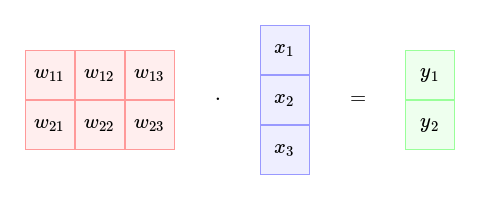

We want to derive each output feature $y_i$ with respect to $\vec{x}$. So let's expand the features of $\vec{y}$ into a vector.
$$
\frac{\partial \vec{y}}{\partial \vec{x}}  =    
\begin{bmatrix}
\frac{\partial y_1}{\partial \vec{x}}\\
\frac{\partial y_2}{\partial \vec{x}}\\
\end{bmatrix}
   $$
   
Let's take it a step further - we want derive **each output feature** with respect to **each input feature**. So, let's expand the features of $\vec{x}$ as columns.

$$
\left[\frac{\partial \vec{y}}{\partial \vec{x}}\right] =    
\begin{bmatrix}
\frac{\partial y_1}{\partial \vec{x}}\\
\frac{\partial y_2}{\partial \vec{x}}\\
\end{bmatrix} = 
\begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \frac{\partial y_1}{\partial x_3}\\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \frac{\partial y_2}{\partial x_3}\\
\end{bmatrix}
   $$

This gives us a matrix of all partial derivatives, which is also called the **Jacobian matrix**. 

Let's get the actual values of the derivatives for the matrix multiplication. here, the output elements were computed by:

$$
y_1 = w_{11} * x_1 + w_{12} * x_2 + w_{13} * x_3\\
y_2 = w_{21} * x_1 + w_{22} * x_2 + w_{23} * x_3
$$


Now, let's focus on the single input element $x_1$. The graph below shows how $x_1$ contributes to the output. Note: In the full computational graph, there are more arrows pointing to $y_1$ and $y_2$ which are not shown in the graph.

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/dp_matrix_pic1.png" width="512" alt="internet connection needed">

To derive $f$ with respect to $x_1$, we must sum over all paths to which $x_1$ contributes (multivariable chain rule). So:

 

\begin{equation*}
\delta_1^{(x)} =  \frac{\partial f}{\partial x_1} = \frac{\partial f}{\partial y_1} \frac{\partial y_1}{\partial x_1} + \frac{\partial f}{\partial y_2} \frac{\partial y_2}{\partial x_1}
\end{equation*}

or in general:

\begin{equation*}
\delta_j^{(x)} = \sum_i \frac{\partial f}{\partial y_i} \frac{\partial y_i}{\partial x_j} 
\label{eq:delta_x} \tag{1}
\end{equation*}

<!-- You find the values for all these partial derivatives in $\delta^{(y)}$ (the error responsibilities for $y$) and the Jacobian matrix.-->


**Task:**

Show that the gradient w.r.t $\vec x$ is $$
\vec \delta^{(x)} = W^T \vec \delta^{(y)}.
$$

Hint: Use equation $\eqref{eq:delta_x}$.


### Row vectors

In the previous exercise, $\vec x$ was a column vector. If $\vec a$ is a row vector instead, the order of $\vec a$ and $V$ is reversed in the dot product (forward pass).

$$
\vec b : \mathbb{R}^J \to \mathbb{R}^I
$$

$$
\vec b = \vec a \cdot  V
$$
Note $\vec b$ is also a row vector.

$$
f(\vec b) = f(\vec b(\vec a))
$$

### Task

How do we calculate $\vec \delta^{(a)}$ in vectorized form now?

Note: $\vec \delta^{(a)}$ is now a row vector.

#### Matrix-Matrix product

We can generalize what we learnt about the matrix-vector product chain rule to a
matrix-matrix product.

We have:
$$W \cdot X = Y$$

$X$ and $Y$ are now matricies. Both have $K$-columns.

Note that the matrix-matrix dot product is equivalent to:

$$
W \cdot X = 
\begin{pmatrix}W \vec x_1 & W \vec x_2 & \dots & W \vec x_K 
\end{pmatrix} =
\begin{pmatrix}
\vec y_1 & \vec y_2 & \dots & \vec y_K
\end{pmatrix} = Y
$$
with 
- the column vectors $\vec x_k$ of $X$ and
- the column vectors $\vec y_k$ of $Y$.

In other words, a column vector of $Y$ is computed by the dot product of $W$ with a column vector of $X$:

$$
\vec y_k = W \cdot \vec x_k
$$



From our result above, we know that the gradient vectors are connected by

$$
\vec \delta_k^{(x)} = W^T \cdot \vec \delta_k^{(y)}.
$$

We store all values of the $\vec \delta_k^{(x)}$ and $\vec \delta_k^{(y)}$
in the matricies $\hat \delta^{(x)}$ respectively $\hat \delta^{(y)}$.
The $\vec \delta_k^{(x)}$ and $\vec \delta_k^{(y)}$ are the column vectors of the matricies.
Then the "backprop rule" for the dot-product $Y=W\cdot X$ is:

$$
\hat \delta^{(x)} = W^T \cdot \hat \delta^{(y)}
$$


#### Task

For the dot-product $Y=W\cdot X$:

What is the "backprop rule" for $\hat \delta_k^{(w)}$?

## Autodiff class `Node` 

Deep learning frameworks support automatic differentiation via backpropagation through the computational graph.  To demonstrate how autodiff works we implement an autodiff python class `Node`.

The syntax of this class should be familiar to you from the exercise [Automatic Differentiation for Scalars](https://gitlab.com/deep.TEACHING/educational-materials/blob/master/notebooks/differentiable-programming/exercise-automatic-differentiation-scalar.ipynb) (see [Requirements](#Requirements)) - so we won't go as much into detail about it again.

Note: We have to add multiple path to the same variable as the multivariable chain rule tells us. In the implementation, we store the partial derivatives in a python `dict`ionary. We need a helper function `combine_dicts` for taking the _multivariate chain rule_ into account (see notebook _Automatic Differentiation for Scalars_ ):

In [3]:
def combine_dicts(a, b, op=operator.add):
    x = (list(a.items()) + list(b.items()) +
        [(k, op(a[k], b[k])) for k in set(b) & set(a)])
    return {x[i][0]: x[i][1] for i in range(0, len(x))}

In [4]:
# Here you see how combine dicts work
a = {'a': 2, 'b':3, 'c':4}
b = {'a': 5, 'c':6, 'x':7}
combine_dicts(a, b)

{'a': 7, 'b': 3, 'c': 10, 'x': 7}

In [5]:
# and another example
A = {'a':-1.3, 'b':-4, 'c':3}
B = {'b':3, 'c':4, 'd':5}
combine_dicts(A,B)

{'a': -1.3, 'b': -1, 'c': 7, 'd': 5}

### Node class
Below is a skeleton for the node class and a number of helper functions.

In [6]:
class Node(object):    
    
    def __init__(self, value, name=None):      
        value = Node._wrap_2d(value)
        self._set_variables(name, value)
        # only 2D-Arrays are supported at the moment
        assert len(self.shape)==2

    
    # Sets input variables and provides the grad function    
    def _set_variables(self, name, value):
        self.value = value
        
        # add shape and dtype for Node
        self.shape = value.shape
        self.dtype = value.dtype
        
        # analog to notebook "Automatic Differentiation for Scalars":
        self.name = name
        if name:
            self.grad = lambda g : {name : g}
        else: 
            self.grad = lambda g : {}
    


### 2D Helper

The value of each Node is a 2D numpy array. This consistency is important. All operators we're going to implement handle 2D numpy arrays. Node objects are initialized with a `value` and optionally a name.

**Task:** Implement the `_wrap_2d` helper function.
* If the argument `value` is a scalar, return `value` as a 2D numpy array (shape (1,1))
* If `value` is a 1D (numpy) array, return it as a 2D column vector (shape (n,1))

In [7]:
# Ensure that the value is a 2D numpy array.
# Scalars and 1D values are wrapped as a 2D array.
def _wrap_2d(value):
    raise NotImplementedError()

# add to Node class
Node._wrap_2d = _wrap_2d

In [9]:
assert np.array_equal([[3]], Node(3).value)
assert np.array_equal([[3]], Node(np.array([3])).value)
assert np.array_equal([[3]], Node(np.array([[3]])).value)

assert Node(np.array([1,2,3])).shape == (3,1)

### Operators

Now we can start adding operators and their derivatives. The syntax should be familiar to you from the notebook _Automatic Differentiation for Scalars_.

The only things that have changed:
* The `value` of each node is a 2D array.

Note that the addition is only allowed for 2D arrays that have equal shape. We are going to handle broadcasting later.

In [10]:
def __add__(self, other):
    
    # if the the value of other is a number wrap it in a Node:
    if isinstance(other, numbers.Number):
        other = Node(np.array([[other]]))
        
    # forward pass
    ret = Node(self.value + other.value)
    
    # for backward pass
    def grad(g):   
        # derivative root w.r.t self and other
        g_total_self = g 
        g_total_other = g
        x = combine_dicts(self.grad(g_total_self), other.grad(g_total_other))
        return x
    ret.grad = grad
    return ret

Node.__add__ = __add__

To make this more clear, we use an example.

Assume we have an add-node in our computational graph:

$$
C = A + B
$$
with the $I\times J$-matricies
$A$, 
$B$ and 
$C$.

The scalar output of the graph is
$$
f = \sum_{ij} C_{ij}
$$

The gradient vector is defined by the vectorized version of $C$, e.g., 
$\vec c$ with elements $c_k$ ($K$ is the number of elements).
Each $c_k$ correspond to a entry of the matrix $C_{ij}$, so $K=I*J$

$$
\frac{\partial f}{\partial \vec c} = \begin{pmatrix} 
\frac{\partial f}{\partial c_1}\\
\vdots \\
\frac{\partial f}{\partial c_k}\\
\vdots \\
\frac{\partial f}{\partial c_K}\\
\end{pmatrix}
$$

However, that's not the way we implement it. In the implementation, we use a matrix for the gradient of $f$ with respect to $C$:
 
$$
\frac{\partial f}{\partial C} = \begin{pmatrix} 
\frac{\partial f}{\partial C_{11}} & \dots & \frac{\partial f}{\partial C_{1j}} &\dots & \frac{\partial f}{\partial C_{1J}}\\
\vdots & \ddots & \vdots & \ddots & \vdots\\
\frac{\partial f}{\partial C_{i1}} & \dots & \frac{\partial f}{\partial C_{ij}} &\dots & \frac{\partial f}{\partial C_{iJ}}\\
\vdots & \ddots &  \vdots & \ddots & \vdots \\
\frac{\partial f}{\partial C_{I1}} & \dots & \frac{\partial f}{\partial C_{Ij}} &\dots & \frac{\partial f}{\partial C_{IJ}}\\
\end{pmatrix}
$$


#### Task

What values have the entries of $\frac{\partial f}{\partial C_{ij}}$.

Note: You need the result to implement the sum operator.

From the multivariate chain rule
$$
\frac{\partial f}{\partial b_{l}} = \sum_{k} \frac{\partial f}{\partial c_{k}}\frac{\partial c_{k}}{\partial b_{l}}
$$

follows for our matrix version:
$$
\frac{\partial f}{\partial B_{ij}} = \sum_{m,n}\frac{\partial f}{\partial C_{mn}}\frac{\partial C_{mn}}{\partial B_{ij}} 
$$

For the matrix addition, we have $$
\frac{\partial C_{mn}}{\partial B_{ij}} = \delta_{mi} \delta_{nj} 
$$

So, we get 
$$
\frac{\partial f}{\partial B_{ij}} = 1
$$ for all $i,j$-pairs.

This seems to by an overcomplicated derivation for a simple result. However,
we need a similar derivation to show how broadcasting works. 

If the argument is a number, we wrap it as a Node so both of the expressions `node + 1` and `node + Node(1)` are equivalent and valid.

In [11]:
node = Node(np.arange(6).reshape((2,3)))
a = (node + 1).value
b = (node + Node(1)).value
assert np.array_equal(a, b)

The way we compute gradients is similar to how we handled scalars, see [Automatic Differentiation for Scalars](./exercise_automatic_differentiation_scalar.ipynb) for a more detailed explanation.

We use the helper function
```Node._set_grad(self, g_total_self, other, g_total_other)``` which
* handles broadcasting
* calls self.grad(g_total_self)
* calls other.grad(g_total_other)

This produces a dictionary of gradients for each branch leading up to `C`. The function combines these gradients and returns the combined dictionary.

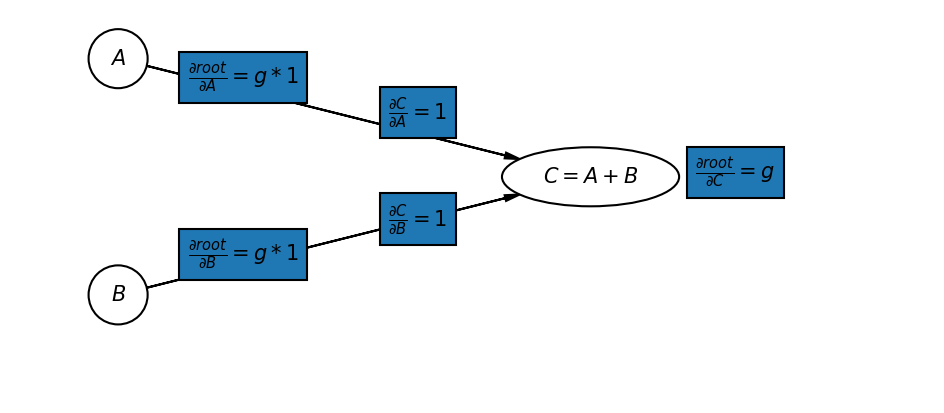

#### Task: Implement the Sum-Operator

Here, should implement a `_sum_all()`-operator.
In the forward pass, `_sum_all()` should add up all elements of the input matrix.
The output is a matrix with shape $(1,1)$.
So, we can use it to realize the `f`-node output of the example above.

We call the operation `_sum_all()` because there is no [`axis`-argument](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html).


Optionally (for experts): Implement a `sum()`-operator which supports an `axis`-argument.

In [12]:
def _sum_all(self):
    ret = None # Your work
    def grad(g): 
        x = None # Your work
        return x
    ret.grad = grad
    return ret


Node.sum_all = _sum_all

### Operators - Multiply

Assume we have an element-wise multiplication (`*`) node
in our computational graph:

$$
C = A * B
$$
with the $I\times J$-matricies
$A$, 
$B$ and 
$C$.

The scalar output of the graph is
$$
f = \sum_{ij} C_{ij}
$$

What is $\frac{\partial f}{\partial B_{ij}}$?

Hint: Use the matrix version of the multivariate chain rule 

$$
\frac{\partial f}{\partial B_{ij}} = \sum_{m,n}\frac{\partial f}{\partial C_{mn}}\frac{\partial C_{mn}}{\partial B_{ij}} 
$$


**Task:** Implement the (element-wise) multiplication operator.

In [14]:
def __mul__(self, other):
    raise NotImplementedError()

Node.__mul__ = __mul__

In [16]:
# implicit forward pass:
a = Node(np.array([[1,1,1], [2,2,2]]), "A")
b = Node(np.array([[10, 20, 30], [10, 20, 30]]), "B")
c = a * b
f = c.sum_all()
assert np.array_equal(c.value, np.array([[10, 20, 30], [20, 40, 60]]))

# backward pass:
grads = f.grad(1) # gradient of C w.r.t A and B

assert np.array_equal(grads['A'], np.array([[10, 20, 30], [10, 20, 30]]))
assert np.array_equal(grads['B'], np.array([[1, 1, 1], [2, 2, 2]]))

#### Broadcasting

This was our first trial to implement `+` and `*`.
However, what happens if we want to use [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html), e.g.:


    a = Node(np.array([[1,1], [2,2]]), "a")
    b = Node(np.array([[10, 20]]), "b")
    c = a * b
    f = c.sum()

To make this more clear, we use our modified example.

Assume we have an element-wise multiplication-node in our computational graph (which supports broadcasting):

$$
C = A * B
$$
with the $I\times J$-matricies
$A$ and $C$. $B$ is now a $1 \times J$-matrix. 

The scalar output of the graph is
$$
f = \sum_{ij} C_{ij}
$$

Note that broadcasting tells us how to compute an element of $C$:

$$
C_{mn} = A_{mn} * B_{1n}$$


We can use the multivariable chain rule to show how braodcasting must be taken into account for backprop:

For the gradient w.r.t. $B$:
$$
\begin{align}
\frac{\partial f}{\partial B_{1j}} &=  \sum_{m,n}\frac{\partial f}{\partial C_{mn}}\frac{\partial C_{mn}}{\partial B_{1j}} \\
&= \sum_{m,n}1 * \frac{\partial\left( A_{mn} * B_{1n} \right)}{\partial B_{1j}} \\
&= \sum_{m} \frac{\partial\left( A_{mj} * B_{1j} \right)}{\partial B_{1j}} \\
&= \sum_{m} A_{mj}\\
\end{align}
$$

and the gradient w.r.t. $A$:

$$
\begin{align}
\frac{\partial f}{\partial A_{ij}} &=  \sum_{m,n}\frac{\partial f}{\partial C_{mn}}\frac{\partial C_{mn}}{\partial A_{ij}} \\
&= \sum_{m,n}1 * \frac{\partial\left( A_{mn} * B_{1n} \right)}{\partial A_{ij}} \\
&= \sum_{m} \frac{\partial\left( A_{mj} * B_{1j} \right)}{\partial A_{ij}} \\
&= B_{1j} 
\end{align}
$$

#### Task

Maybe, this was a litle bit to abstract. To make it more clear work through the example in pen & paper exercise:

$$
A =\begin{pmatrix}
1 & 1 \\
3 & 4
\end{pmatrix}
$$

and $C = A*B$ using broadcasting. The output node is $f = \sum_{ij} C_{ij}$.
    
- What is the `shape` of $C$?
- What is the `shape` of the gradient $\frac{\partial f}{\partial B}$?
- Compute by hand the gradient of $f$ w.r.t. (with respect to) $A$, i.e. $\frac{\partial f}{\partial A}$.
- Compute by hand the gradient of $f$ w.r.t. (with respect to) $B$, i.e. $\frac{\partial f}{\partial B}$. Which rule have we take into account for computing the gradient w.r.t. $B$? 

Hint: Think about "How are the four elements of $C$ computed by the two elements of $B$. How many paths (in backward direction) are going to the elements of $B$?" You can also use a computational graph with nodes for all elements of $A$,$B$ and $C$ (as in the exercises above).

#### Implementation of broadcasting

So, broadcasting make things slightly more complicated.
We have to take the _multivariable chain rule_ into account. 
So, we must `sum` over all pathes in the implementation of
`_broadcast_g_helper` for our `Node`-class:

In [19]:
def _broadcast_g_helper(o, o_): 
    # Take the multivariable chain rule into account:
    if o_.shape[0] > o.shape[0]:
        o_ = o_.sum(axis=0).reshape(1,-1)
    if o_.shape[1] > o.shape[1]:
        o_ = o_.sum(axis=1).reshape(-1,1)
    return o_
 
Node._broadcast_g_helper = _broadcast_g_helper

For all binary operators, we have to call the broadcast helper
for both branches, call the `grad` function of each input and have to combine the dicts. So, we write a convenience function `_set_grad` for our `Node`-class:

In [20]:
def _set_grad(self_, g_total_self, other, g_total_other):
        g_total_self = Node._broadcast_g_helper(self_, g_total_self)
        g_total_other = Node._broadcast_g_helper(other, g_total_other)
        x = combine_dicts(self_.grad(g_total_self), other.grad(g_total_other))
        return x
    
Node._set_grad = _set_grad

Our new implementation of `__add__` is nearly the same.
Only one line changes:

In [21]:
def __add__(self, other):
    
    # if the the value of other is a number wrap it in a Node:
    if isinstance(other, numbers.Number):
        other = Node(np.array([[other]]))
        
    # forward pass
    ret = Node(self.value + other.value)
    
    # for backward pass
    def grad(g):   
        # derivative root w.r.t self and other
        g_total_self = g
        g_total_other = g
        # this is the only change we have to do:
        # this line is replaced by
        # x = combine_dicts(self.grad(g_total_self), other.grad(g_total_other))
        # this
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        
        return x
    
    ret.grad = grad
    return ret

Node.__add__ = __add__

#### Task

Implement the new version of `__mul__`.
You just have to copy `g_total_self` and `g_total_other` from your `__mul__`-implementation above.

In [22]:
def __mul__(self, other):
    if isinstance(other, numbers.Number) or isinstance(other, np.ndarray):
        other = Node(other)           
    ret = Node(self.value * other.value) 
    def grad(g):
        g_total_self = None #Your task
        g_total_other = None # Your task
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        return x
    ret.grad = grad
    return ret

Node.__mul__ = __mul__

In [24]:
# This is the example of the pen & paper exercise:

A = Node(np.array([[1,2], [3,4]]), "A")
B = Node(np.array([[10, 20]]), "B")
C = A * B
f = C.sum_all()
grads = f.grad(1)

#print(grads) # comment this out and compare it with your pen & paper result.

In [25]:
# Test for the element-wise multiplication

# implicit forward pass:
a = Node(np.array([[1,1,1], [2,2,2]]), "A")
b = Node(np.array([[10, 20, 30]]), "B")
c = a * b
f = c.sum_all()

assert np.array_equal(c.value, np.array([[10, 20, 30], [20, 40, 60]]))

# backward pass:
grads = f.grad(1) # gradient of C w.r.t A and B

assert np.array_equal(c.value, np.array([[10, 20, 30], [20, 40, 60]]))
assert np.array_equal(grads['A'], np.array([[10, 20, 30],[10, 20, 30]]))
assert np.array_equal(grads['B'], np.array([[3,3,3]]))

### Operators - Dot product

**Task:** Implement the dot product. The exercise [derivative of the dot product](#Derivative-of-the-dot-product) mentions how to differentiate the dot product operator.

In [26]:
def dot(self, other):
    raise NotImplementedError()

Node.dot = dot

Verify your implementation.

In [28]:
a = Node(np.array([[1,2,3],
       [4,5,6]]), "a")
b = Node(np.array([[10,10],
        [20,20],
        [30,30]]), "b")
c = dot(a,b)
assert np.array_equal(c.value, np.array([[140, 140], [320, 320]]))
assert np.array_equal(c.grad(1)['a'], np.array([[10, 20, 30], [10, 20, 30]]))
assert np.array_equal(c.grad(1)['b'], np.array([[1, 4], [2, 5], [3, 6]]))

### Operators - Square

**Task:** Implement the square operator.

In [29]:
def square(self):
    raise NotImplementedError()
    
Node.square = square

In [31]:
# Test for the square-operator

a = Node(np.array([[1,2,3], [4,5,6]]), "a")
b = a.square()
f = b.sum_all()
assert np.array_equal(b.value, np.array([[ 1,  4,  9], [16, 25, 36]]))
assert np.array_equal(b.grad(1)['a'], np.array([[ 2,  4,  6],[ 8, 10, 12]]))

### Additional operators

We extend the Node class with some more operators (which are already fully implemented).

#### Task

What are the meanings of the python magic functions? 
Look the meaning up in https://docs.python.org/3/library/operator.html

In [32]:
def __radd__(self, other):
    return Node(other) + self

def __sub__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other)
    ret = self + (other * -1.)   
    return ret

def __rsub__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other) 
        return other - self
    raise NotImplementedError()      

def __rmul__(self, other):
    if isinstance(other, numbers.Number):
        return Node(other) * self
    raise NotImplementedError()


def __truediv__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(np.array([[other]]))
    ret = Node(self.value / other.value) 
    def grad(g):
        g_total_self = g / other.value
        g_total_other = -1 * self.value * g / (other.value**2)
        x = Node._set_grad(self, g_total_self, other, g_total_other)
        return x
    ret.grad = grad
    return ret

def __rtruediv__(self, other):
    if isinstance(other, numbers.Number):
        other = Node(other)
        return other/self
    raise NotImplementedError()

def __neg__(self):
    return self * -1.

def _sum_(self, axis=None):
    if axis is None:
        return self.sum_all()
    assert axis in (0,1)
    return self._sum(axis)
               
def _sum(self, axis): 
    ret = self.value.sum(axis=axis)
    if axis==0: 
        ret = ret.reshape(1, -1)
    else:
        ret = ret.reshape(-1, 1)
    ret = Node(ret)
    def grad(g):
        x = self.grad(np.ones_like(self.value) * g)
        return x
    ret.grad = grad
    return ret  

    
Node.__radd__ = __radd__
Node.__sub__ = __sub__
Node.__rsub__ = __rsub__
Node.__rmul__ = __rmul__
Node.__truediv__ = __truediv__
Node.__rtruediv__ = __rtruediv__
Node.__neg__ = __neg__
Node._sum = _sum
Node.sum = _sum_

### Node class for Softmax Regression

Here, we want to use the node class for Softmax regression.

Setup for an example data set:

In [33]:
# class 1
# covariance matrix and mean
cov1 = np.array([[4,-1],[-1,4]])
mean1 = np.array([4,4])
# number of data points
m1 = 100

# class 2
# covariance matrix
cov2 = np.array([[3,1.5],[1.5,3]])
mean2 = np.array([-2.,5])
# number of data points
m2 = 100

# class 3
# covariance matrix
cov3 = np.array([[3,1],[1,3]])
mean3 = np.array([0,-1])
# number of data points
m3 = 100

# generate m gaussian distributed data points with
# mean and cov.
r1 = np.random.multivariate_normal(mean1, cov1, m1)
r2 = np.random.multivariate_normal(mean2, cov2, m2)
r3 = np.random.multivariate_normal(mean3, cov3, m3)


X = np.concatenate((r1,r2,r3))
y = np.ones(X.shape[0], dtype=np.int32) * 2
y[:len(r1),] = 0
y[len(r1):len(r1)+len(r2)] = 1

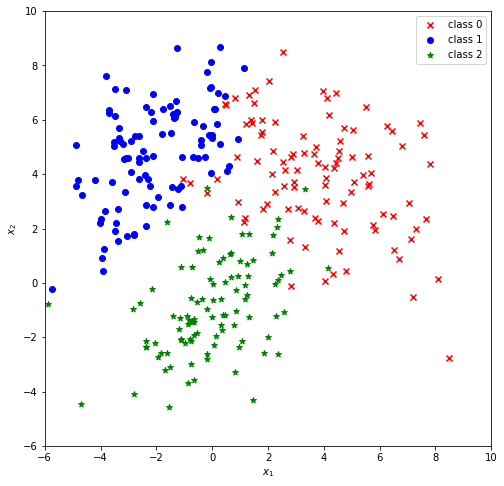

In [34]:
plt.figure(figsize=(8,8))
x1_min= x2_min= -6
x1_max= x2_max= 10
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.scatter(r1[...,0], r1[...,1], c='r', marker='x', label="class 0")
plt.scatter(r2[...,0], r2[...,1], c='b', marker='o', label="class 1")
plt.scatter(r3[...,0], r3[...,1], c='g', marker='*', label="class 2")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

In [35]:
# Add one column for the bias trick
def add_x0(X):
    one_vec = np.ones((X.shape[0],1)) 
    return np.concatenate((one_vec, X), axis=1)

X_train = add_x0(X)

In [36]:
# convert y to one-hot
nb_training_data = y.shape[0]
nb_classes = int(y.max()+1)
y_oh = np.zeros((nb_training_data, nb_classes))
y_oh[range(nb_training_data), y] = 1.

In [37]:
THETA = "theta"
def Softmax_regression_model(theta_, x, y_oh=None):
    # y_oh: one-hot labels
   
    X = Node(x) # no name -> no grad     
    W = Node(theta_, name=THETA) # name -> grad
   
    f = X.dot(W) 
    h = f.softmax() 
    
    if y_oh is not None: # cost function
        t = Node(y_oh)
        assert t.shape == h.shape
        loss = - t * h.log() 
        cost = loss.sum()
        return h, cost 
    
    return h

Once we've computed the loss, we call its grad function `loss.grad(np.ones_like(loss.value))` and get the gradients for all parameters in the forward pass. We apply these gradients in gradient descent.

In [38]:
def gradient_descent(x, y, epochs, theta, alpha=0.001):
    
    #out, cost = Softmax_regression_model(theta, x, y)
    
    for i in range(epochs):
        
        out, cost = Softmax_regression_model(theta, x, y)
        if i%200==0:
            print (i, cost.value)
        
        #backprop
        grad = cost.grad(1.) 
        for g in grad:
            assert g==THETA # we only have only one parameter (matrix)
            gradient = grad[g]
            assert theta.shape == gradient.shape   
            theta -= alpha * gradient 
    return theta



#### Task: Operators for Softmax Regression
Implement `exp`, `log` and `softmax` for the `Node`-class.
Write tests to check your implementation. 

Note: For the tests, you should compute by pen and paper numeric values
for small computational graphs using the operators. Check the
numeric values in the tests.

In [39]:
# 
def exp(self):
    raise NotImplementedError()

def log(self):
    raise NotImplementedError()

def softmax(self):
    raise NotImplementedError()

Node.softmax = softmax
Node.exp = exp
Node.log = log

Now, we'll use gradient descent to map points in (x,y) coordinates to a target class 0 or 1.
In the plot below, the green line marks all points (x,y) where the output of the model is 0.5. It serves as a decision boundary for the model.

In [41]:
theta_fit = gradient_descent(X_train, y_oh, 1000, 
                             np.zeros((3, nb_classes)), alpha=0.002)

# use a closure to store theta_fit for a prediction model
model = lambda x: Softmax_regression_model(theta_fit, x, y_oh=None)

0 [[329.5836866]]
200 [[50.75304675]]
400 [[49.17330126]]
600 [[48.67656768]]
800 [[48.44235252]]


In [42]:
def plot_prediction(model, X, targets=y):    
    fig = plt.figure(figsize=(8,8))

    x1_min= x2_min= -6
    x1_max= x2_max= 10
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    delta = 0.1
    a = np.arange(x1_min, x1_max+delta, delta)
    b = np.arange(x2_min, x2_max+delta, delta)
    A, B = np.meshgrid(a, b)

    x_ = np.dstack((A, B)).reshape(-1, 2)
    out = model(add_x0(x_)).value

    ns = list()
    ns.append(3)
    ns.extend(A.shape)
    
    out = out.T.reshape(ns)

    # TODO: fix colors 
    plt.pcolor(A, B, out[0], cmap="copper", alpha=0.2)
    plt.pcolor(A, B, out[1], cmap='Reds', alpha=0.2)
    plt.pcolor(A, B, out[2], cmap='Blues', alpha=0.2)
    #out.shape
    # lets visualize the data:
    # TODO: fix colors for data points
    plt.scatter(X[:, 1], X[:, 2], c=targets, s=40, cmap=plt.cm.Spectral)

    plt.title("Data and decision boundaries in data space.")

#### Linear Separability

Note: The decision boundaries of softmax regression are lines (in general hyperplanes).

Remember what you have learned about *linear separability* by studying logistic regression.
With (pure) *softmax regression* only linear separable data can be classified with high quality.

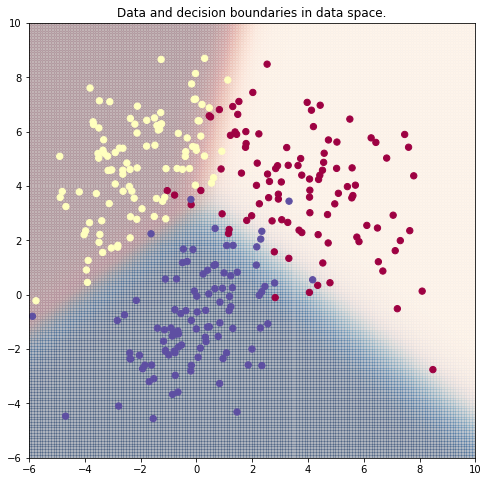

In [43]:
# Task (optionally): Fix the colors
plot_prediction(model, X_train)

## Literature

<table>
    <tr>
        <td>
            <a name="AP17"></a>[AP17]
        </td>
        <td>
            Apache MXNet, "Deep Learning Programming Style". [Online]. Available: <a href="http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html">http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html</a> [Accessed: 17-Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="OLA15"></a>[OLA15]
        </td>
        <td>
            C. Olah, "Calculus on Computational Graphs: Backpropagation" - Blog Article, August 31, 2015. [Online] Available: <a href='http://colah.github.io/posts/2015-08-Backprop/'>http://colah.github.io/posts/2015-08-Backprop/</a> [Accessed: 17- Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="BAY18"></a>[BAY18]
        </td>
        <td>
            Atilim Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, "Automatic differentiation in machine learning: a survey", Journal of Machine Learning Research 18 (2018) 1-43  Apr. 2018. [Online]. Available: <a href="http://jmlr.org/papers/volume18/17-468/17-468.pdf">http://jmlr.org/papers/volume18/17-468/17-468.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="LM"></a>[LM]
        </td>
        <td>
            Erik Learned-Miller, 'Vector, Matrix, and Tensor Derivatives'. [Online]. Available: <a href="http://cs231n.stanford.edu/vecDerivs.pdf">http://cs231n.stanford.edu/vecDerivs.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="KAR"></a>[KAR]
        </td>
        <td>
            A.Karpathy, Lecture Notes CS 231 Convolutional Neural Networks for Visual Recognition: Backpropagation, Year Published. [Online]. Available: <a href="http://cs231n.github.io/optimization-2/">http://cs231n.github.io/optimization-2/)</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="BFO17"></a>[BFO17]
        </td>
        <td>
            B. Fortuner “Loss Functions,” Loss Functions, 2017 Revision 5f00adef. [Online]. Available: <a href='https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html'>https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html</a>. [Accessed: 02-May-2019]. 
        </td>
    </tr>
    
    
    
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Automatic Differentiation for Matrices_ <br/>
by _Christian Herta, Diyar Oktay_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 _Christian Herta, Diyar Oktay_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.